In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skmlm import MLM,MLMC,NN_MLM,OS_MLM,FCM_MLM
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedShuffleSplit,cross_val_score
sns.set_theme(style="darkgrid")
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
import time
from sklearn.metrics import accuracy_score, jaccard_score, precision_score
import RFD_MLM as mlm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_iris,load_wine,load_breast_cancer

## 1. Préparations des données

### 1.1 Chargement de données 

In [3]:
def to_pandas(X,y):
    n = len(X)
    return pd.DataFrame(data = np.concatenate((X,y.reshape((n,1))),axis=1),columns=["c"+str(i) for i in range(X.shape[1]+1)])

# 6 datasets pour la régression 
domain = pd.read_csv("data/abalone.domain",delimiter=":", names=["column","type" ])# Pour charger les noms des dolonnes
abalone = pd.read_csv("data/abalone.data",names=domain.column.to_list()) # charher la dataset, 

domain = pd.read_csv("data/price.domain",delimiter=":", names=["column","type","unknow"])
price = pd.read_csv("data/price.data",names=domain.column.to_list())

domain = pd.read_csv("data/housing.domain",delimiter=":", names=["column","type" ])
housing = pd.read_csv("data/housing.data",names=domain.column.to_list())

domain = pd.read_csv("data/servo.domain",delimiter=":", names=["column","type" ])
servo = pd.read_csv("data/servo.data",names=domain.column.to_list())

# 3 dataset pour la classification
cancer = to_pandas(load_breast_cancer().data,load_breast_cancer().target)
iris = to_pandas(load_iris().data,load_iris().target)
wine = to_pandas(load_wine().data,load_wine().target)
diabetes = pd.read_csv("data/diabetes.csv")


In [8]:
print("Les dimensions des données :")
print("Servo         :",servo.shape)
print("Abalone       :",abalone.shape)
print("housing       :",housing.shape)
print("Auto price    :", price.shape)
print("breast_cancer :",cancer.shape)
print("iris          :",iris.shape)
print("wine          :",wine.shape)
print("Diabetes      :",diabetes.shape)

Les dimensions des données :
Servo         : (167, 5)
Abalone       : (4177, 9)
housing       : (506, 14)
Auto price    : (159, 16)
breast_cancer : (569, 31)
iris          : (150, 5)
wine          : (178, 14)
Diabetes      : (768, 9)


In [5]:
servo.head(2)

,motor,screw,pgain,vgain,class
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252


In [6]:
abalone.head(2)

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7


In [7]:
housing.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,class
0,0.006,18.0,2.31,0,0.538,6.575,65.2,4.090,1,296.0,15.3,396.898,4.98,24.0
1,0.027,0.0,7.07,0,0.469,6.421,78.9,4.967,2,242.0,17.8,396.898,9.14,21.6


In [8]:
price.head(2)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,2,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102,5500,24,30,13950
1,2,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.4,8.0,115,5500,18,22,17450


In [9]:
diabetes.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


### 1.2 Prétraitements

In [4]:

def split_and_norm(X,y,name,test_size=1/3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=42)    
    if name == "c":
        rus = RandomUnderSampler(random_state=42) # equilibré les proportions de classes
        X,y = rus.fit_resample(X,y)
        sss = StratifiedShuffleSplit(n_splits=1, test_size=1/3,random_state=42)
        for train_idx,test_idx in sss.split(X,y):
            X_train,X_test=X[train_idx],X[test_idx]
            y_train,y_test=y[train_idx],y[test_idx]
    # centrer réduire
    mx = X_train.mean(axis=0)
    ecart1 = X_train.std(axis=0)
    return (X_train-mx)/ecart1,(X_test-mx)/ecart1,y_train,y_test

def preprocessing(dataset):
    # séparer les colonnes en deux types catégorielles et numériques
    cat_col=[col for col in dataset.columns if dataset[col].dtype=='object']
    num_col=[col for col in dataset.columns if dataset[col].dtype=='int64' or dataset[col].dtype=='float64']
    # garder uniquement les colonnes catégorielles et supprimer les valeurs manquantes 
    dataset = dataset[num_col].dropna(axis=0)
    # 10 pérmutation aléatoire pour mélanger les données 

    for i in range(10):
        dataset=shuffle(dataset,random_state=0)
    data = dataset.to_numpy()
    size = data.shape[1]
    X = data[:,:size-1]
    y = data[:,size-1]
    return X,y


In [7]:
def mlm_test(dataset,name,dist="euclidean"):
    L = []
    X,y = preprocessing(dataset)
    X_train, X_test, y_train, y_test = split_and_norm(X,y,name,test_size=1/3)
    y_train = y_train.reshape((len(y_train),1))
    y_test = y_test.reshape((len(y_test),1))
    if name == "r":
        for i in np.arange(5,105,5): 
            clf = MLM(rp_number=i/100,dist = dist)
            clf.fit(X_train,y_train)
            ypred = clf.predict(X_test)
            L.append((mean_squared_error(ypred,y_test),i/100))
        return sorted(L, key = lambda couple : couple[0])[0]
    elif name== "c" :

        for i in np.arange(5,105,5): 
            clf = NN_MLM(rp_number=i/100,dist=dist)
            score = cross_val_score(clf,X_train,y_train,cv=10,scoring="accuracy").mean()
            L.append((score,i/100))
        res = sorted(L, key = lambda couple : couple[0],reverse=True)[0]   
        clf = NN_MLM(rp_number=res[1],dist=dist)
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test)
        return accuracy_score(pred,y_test)


In [6]:
def grid_search_param(x,y,name):
    
    # je définie les paramètres du grid search 
    param_grid = {'C': np.logspace(-2, 10, 10),  
                  'gamma': np.logspace(-2, 10, 10), 
                  'kernel': ['rbf']}

    if name == 'r':
        grid = GridSearchCV(SVR(), param_grid) 
    elif name =='c':
        param_grid = {'C': np.logspace(-2, 10, 10),  
                  'gamma': np.logspace(-2, 10, 10), 
                  'kernel': ['rbf']}
        
        grid = GridSearchCV(SVC(),param_grid) 
    # entrainement du modèle 
    grid.fit(x,y.reshape(len(y))) 
    # affichage des meilleurs hyper paramètres
    #print(grid.best_params_) 

    # affciher l'état du modèle avec les meilleurs paramètres trouvés
    #print(grid.best_estimator_) 
    return grid.best_params_

def svm_test(dataset,name):
    X,y = preprocessing(dataset)# pré traiter les données
    x_train, x_test, y_train, y_test = split_and_norm(X,y,name,test_size=1/3)# divisier les données et normaliser 
    g = grid_search_param(x_train,y_train,name)# optimiser les hyper paramètres 
    if name == "r":
        clf = SVR(C= g['C'], gamma= g['gamma'], kernel= g['kernel'])
    elif name == "c":
        clf = SVC(C= g['C'], gamma= g['gamma'], kernel= g['kernel'])
        
    
    if name == "r":
        tps1 = time.time()
        clf.fit(x_train,y_train)
        pred = clf.predict(x_test)# prediction
        tps2 = time.time()
        return mean_squared_error(pred,y_test)# calcul du score
    elif name == "c":
        tps1 = time.time()
        clf.fit(x_train,y_train)
        score = clf.score(x_test,y_test)
        tps2 = time.time()
        return score


def rf_test(dataset,name):
    X,y = preprocessing(dataset)# pré traiter les données
    x_train, x_test, y_train, y_test = split_and_norm(X,y,name,test_size=1/3)# divisier les données et normaliser 

    if name == 'r':
        param_grid = {'max_depth': [10,20,40,60,80,100],
              'criterion':['mse'],
              'min_samples_split': [2, 5, 10,15],
              'n_estimators': [100, 150, 200, 250, 300, 350, 400]}
        grid = GridSearchCV(RandomForestRegressor(),param_grid) 
    elif name =='c':
        param_grid = {'max_depth': [10,20,40,60,80,100],
              'criterion':['gini'],
              'min_samples_split': [2, 5, 10,15],
              'n_estimators': [100, 150, 200, 250, 300, 350, 400]}
        grid = GridSearchCV(RandomForestClassifier(),param_grid) 
    # entrainement du modèle 
    grid.fit(x_train,y_train) 
    clf = grid.best_estimator_
    pred = clf.predict(x_test)# prediction
    if name == "r":
        return mean_squared_error(y_test,pred)
    elif name == "c":
        return accuracy_score(y_test,pred)


## 2. Test sur des problèmes de régressions

### Servo dataset
#### a) Minimal Learning Machine 

In [11]:
ser = mlm_test(servo,"r",1/3)
print("Score : {}, nombre de points référence associé : {} %".format(ser[0],ser[1]))

Score : 0.6240813489669005, nombre de points référence associé : 0.3 %


#### b) SVM 

In [70]:
print("Score : ",svm_test(servo,"r"))

Score :  (1.2467975782861096, 0.003000497817993164)


#### c) Decision Tree

In [139]:
print("Score : ",rf_test(servo,"r"))

NameError: name 'parameters' is not defined

### 2.2 Dataset Auto Price

#### a) MLM

In [14]:
pri = test(price,"r",1/3)
print("Meilleur score : {}, Nombre de point références associé : {} %".format(pri[0],pri[1]))

Meilleur score : 3099576.643231837, Nombre de point références associé : 0.75 %


#### b) SVM 

In [71]:
print("Score : ",svm_test(price,"r"))

Score :  (5388256.196759264, 0.005002498626708984)


#### c) Decision Tree

In [155]:
print("Score : ",dt_test(price,"r"))

Score :  6689661.947684507


### 2.3 Dataset Boston Housing

In [143]:
ds_regression = {"servo":servo,"price":price,"housing":housing,"abalone":abalone}
ds_classification = {"iris":iris,"wine":wine,"diabetes":diabetes,"cancer":cancer}
for name,ds in ds_classification.items():
    print("Dataset "+name+" ################################")
    print(rf_test(ds,"c"))

Dataset iris ################################
0.96
Dataset wine ################################
0.9583333333333334
Dataset diabetes ################################
0.7932960893854749
Dataset cancer ################################
0.9788732394366197


#### a) MLM

In [15]:
hou = test(housing,"r",1/3)
print("Meilleur valeur : {}, Nombre de point références associé : {} %".format(hou[0],hou[1]))

Meilleur valeur : 24.157636881665386, Nombre de point références associé : 0.85 %


#### b) SVM

In [ ]:
print("Score : ",svm_test(housing,"r"))

#### c) Decision Tree

In [142]:
print("Score : ",rf_test(housing,"r"))

Score :  13.732484217455612


### 2.4 Dataset Abalone 

#### a) MLM

In [16]:
aba = test(abalone,"r",1/3)
print("Meilleur valeur : {}, Nombre de point références associé : {}".format(aba[0],aba[1]))

Meilleur valeur : 4.991579625045996, Nombre de point références associé : 0.1


#### b) SVM

In [144]:
print("Score : ",svm_test(abalone,"r"))

Score :  5.041134592485038


#### c) Decision Tree

In [157]:
print("Score : ",dt_test(abalone,"r"))

Score :  6.222055403070914


In [144]:
import time
def getData(data,name):
    arr = np.zeros((len(data),3))
    for i in range(len(data)):
        if name == "r":
            arr[i,:] = np.array([(mlm_test(data[i],"r",1/3)[0],svm_test(data[i],"r")[0],dt_test(data[i],"r")[0])])
        elif name == "c":
            arr[i,:] = np.array([(mlm_test(data[i],"c",1/3)[0],svm_test(data[i],"c")[0],dt_test(data[i],"c")[0])])
    
    return arr
classif = np.array([['0.98','0.979','0.748','0.971'],['0.98','0.875','0.782','0.978'],['0.96','0.958','0.793','0.978']])
data=[iris,wine,diabetes,cancer]   
df = pd.DataFrame(data=classif.T,columns=["MLM","SVM","RF"],
             index=["Iris","Wine","Prima Indians Diabetes","Wisconsin Breast Cancer"])

display(df.style.apply(highlight_max,axis=1))



,MLM,SVM,RF
Iris,0.98,0.98,0.96
Wine,0.979,0.875,0.958
Prima Indians Diabetes,0.748,0.782,0.793
Wisconsin Breast Cancer,0.971,0.978,0.978


In [71]:
regr = np.array([['6.24e-1','3.09+e6','2.41e+1','4.99'],
                  ['6.9-1','5.74e+6','2.36e+1','4.5'],
                  ['6.14e-1','3.03e+6','1.4e+1','5.17']])
df = pd.DataFrame(data=regr.T,columns=["MLM (C)"," SVM (RBF)","RF "],
             index=["Servo","Auto price","Boston Housing","Abalone"])

display(df.style.apply(highlight_min,axis=1))

,MLM (C),SVM (RBF),RF
Servo,6.24e-1,6.9-1,6.14e-1
Auto price,3.09+e6,5.74e+6,3.03e+6
Boston Housing,2.41e+1,2.36e+1,1.4e+1
Abalone,4.99,4.5,5.17


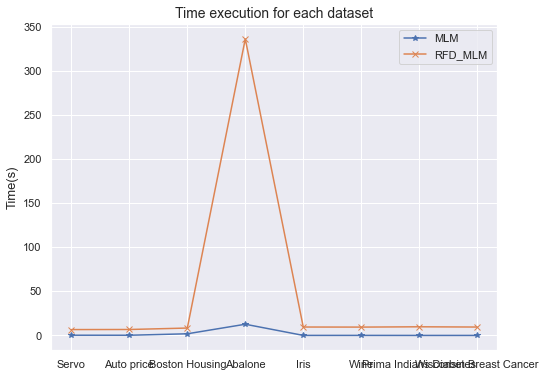

In [56]:
rfd_time = [6.63,6.73,8.36,335.99,9.53,9.44,9.79,9.51]
d = [(servo,0.3,'r'),(price,0.75,'r'),(housing,0.85,'r'),(abalone,0.1,'r'),(iris,0.95,'c'),
           (wine,1,'c'),(diabetes,0.1,'c'),(cancer,0.2,'c')]

mlm_time = []
for i in range(len(d)):
    X,y = preprocessing(d[i][0])
    X_train,X_test,y_train,y_test=split_and_norm(X,y,d[i][2])
    y_train = y_train.reshape((len(y_train),1))
    y_test = y_test.reshape((len(y_test),1))
    start = time.time()
    if d[i][2] == 'r':
        clf = MLM(d[i][1])
    else:
        clf = NN_MLM(d[i][1])
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    mlm_time.append(time.time()-start)
    
plt.figure(figsize=(8,6))
plt.title("Time execution for each dataset",fontsize=14)
plt.plot(mlm_time,'-*',label="MLM")
plt.plot(rfd_time,'-x',label="RFD_MLM")
plt.xticks(np.arange(8),
plt.ylabel("Time(s)",fontsize=13)
plt.legend()
plt.show()

In [60]:
df = pd.DataFrame(data=np.array([mlm_time,rfd_time]).T,columns=["MLM ","RFD_MLM"],
             index=["Servo","Auto price","Boston Housing","Abalone","Iris","Wine","Prima Indians Diabetes","Wisconsin Breast Cancer"])
df

,MLM,RFD_MLM
Servo,0.248019,6.63
Auto price,0.208817,6.73
Boston Housing,1.863840,8.36
Abalone,12.681303,335.99
Iris,0.040002,9.53
Wine,0.048004,9.44
Prima Indians Diabetes,0.003001,9.79
Wisconsin Breast Cancer,0.003144,9.51


### Comparaison des résultats avec différentes metric pour le calcul des distances 

In [61]:
distances = ['euclidean','canberra','chebyshev','cityblock','sqeuclidean']
data = [iris,wine,diabetes,cancer]
scores_r = []
for i in range(len(data)):
    X,y = preprocessing(data[i])
    rus = RandomUnderSampler(random_state=42) # equilibré les proportions de classes
    X,y = rus.fit_resample(X,y)
    L = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)    
        mx,ecart = X_train.mean(0),X_train.std(0)
        X_train,X_test = (X_train-mx)/ecart,(X_test-mx)/ecart
        y_train = y_train.reshape((len(y_train),1))
        y_test = y_test.reshape((len(y_test),1))
        clf=NN_MLM(1)
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test)
        L.append(accuracy_score(y_test,pred))
    scores_r.append(np.mean(L))

    


In [62]:
scores_r

[0.844, 0.975, 0.7798882681564245, 0.967605633802817]

In [63]:
({'classification': [0.9359999999999999,
   0.975,
   0.7508379888268156,
   0.9633802816901408],
  'regression': [1.1498193166748405,
   5746245.372060936,
   13.509830106508872,
   4.801612950466618]},
 {'classification': [0.9359999999999999,
   0.9625,
   0.7396648044692737,
   0.9690140845070422],
  'regression': [1.151710651545938,
   30016305.74791224,
   12.197427018143403,
   5.15553863953056]})
#sr = [('0.634', '0.614'),('3.59e+6', '3.13e+6'),('11.941', '13.445'),('5.743', '5.337')]
#sc = [('0.96', '0.96'),('0.958', '0.958'),('0.957', '0.964'),('0.787', '0.798')]
sc_mlm = ['1.25', '6.80e+6', '10.69', '5.07','0.84', '0.975', '0.779', '0.967']
sc_rf = ['1.14','3.13e+6','13.5','4.80','0.935','0.975','0.750','0.963']
sc_rf_mlm = ['1.15','3.59e+6','12.1','5.15','0.935','0.962','0.739','0.969']
u = np.array([sc_rf_mlm,sc_rf,sc_mlm]).T
df = pd.DataFrame(data=u[:4],columns=["RFD_MLM","RF"," MLM"],
             index=["Servo","Auto price","Boston Housing","Abalone"])
display(df.style.apply(highlight_min,axis=1))


,RFD_MLM,RF,MLM
Servo,1.15,1.14,1.25
Auto price,3.59e+6,3.13e+6,6.80e+6
Boston Housing,12.1,13.5,10.69
Abalone,5.15,4.80,5.07


In [64]:
df = pd.DataFrame(data=u[4:],columns=["RFD_MLM","RF"," MLM"],
             index=["Iris","Wine","Prima Indians Diabetes","Wisconsin Breast Cancer"])
display(df.style.apply(highlight_max,axis=1))


,RFD_MLM,RF,MLM
Iris,0.935,0.935,0.84
Wine,0.962,0.975,0.975
Prima Indians Diabetes,0.739,0.750,0.779
Wisconsin Breast Cancer,0.969,0.963,0.967


In [51]:

a = np.array([["6.24e-1" ,"9.05e-1","6.22e-1"],["3.09e+6 ","5.74e+6" ,"5.54e+6"],["2.41e+1", "2.36e+1", "1.9e+1"],["4.99" , "5.04", "6.22"]])
df = pd.DataFrame(data=a,columns=["MLM"," SVM (RBF)","Decision Tree"],
             index=["Servo","Auto price","Boston Housing","Abalone"])

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

display(df.style.apply(highlight_min,axis=1))


,MLM,SVM (RBF),Decision Tree
Servo,6.24e-1,9.05e-1,6.22e-1
Auto price,3.09e+6,5.74e+6,5.54e+6
Boston Housing,2.41e+1,2.36e+1,1.9e+1
Abalone,4.99,5.04,6.22


In [195]:
pd.DataFrame(data=optimal_klist,columns=distances,
             index=["Servo","Auto price","Boston Housing","Abalone"])

,euclidean,canberra,chebyshev,cityblock,sqeuclidean
Servo,0.30,0.30,0.30,0.30,0.05
Auto price,0.75,0.95,0.15,0.70,0.15
Boston Housing,0.85,0.55,0.25,0.55,0.10
Abalone,0.10,0.10,0.10,0.05,0.05


### 2.5 Evolution de l'erreur en fonction du nombre de point références 

In [71]:
def compute_errors(data):
    X,y=preprocessing(data)
    L = []
    x_train, x_test, y_train, y_test = split_and_norm(X,y,"c",test_size=1/3)
    for i in np.arange(5,105,5):  
        clf = MLMC(rp_number=i/100)
        clf.fit(x_train,y_train.reshape((len(y_train),1)))
        y_pred = clf.predict(x_test)
        L.append(1-mean_squared_error(y_pred,y_test)/mean_squared_error(y_pred,np.zeros(len(y_pred))))
    return L

servo_errors = compute_errors(iris)


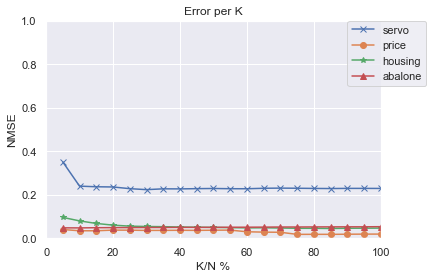

In [49]:
plt.figure()
plt.title("Error per K")
plt.plot(np.arange(5,105,5),servo_errors,"-x",label="servo")
plt.plot(np.arange(5,105,5),price_errors,"-o",label="price")
plt.plot(np.arange(5,105,5),housing_errors,"-*",label="housing")
plt.plot(np.arange(5,105,5),abalone_errors,"-^",label="abalone")
plt.xlabel("K/N %")
plt.ylabel("NMSE")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
plt.ylim((0.,1.))
plt.xlim((0,100))
plt.show()

### 2.6 Optimal K value over different runs

<Figure size 432x288 with 0 Axes>

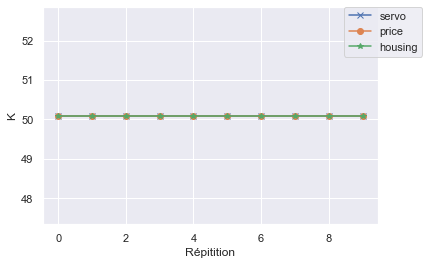

In [50]:
def optimal_k_over(dataset,name):
    X,y = preprocessing(servo)
    y = y.reshape((len(y),1))
    x_train, x_test, y_train, y_test = split_and_norm(X,y,"r",test_size=1/3)
    L = []
    for i in range(10):  
        li = []
        for j in np.arange(5,105,5):
            if name == 'r':
                clf = MLM(rp_number=j/100)
            elif name == 'c':
                clf = NN_MLM(rp_number=j/100)
            clf.fit(x_train,y_train)
            score = clf.score(x_test,y_test)
            li.append((score,(j/100)*len(X)))
        L.append(sorted(li, key=lambda x: x[0])[-1])
    return L

servo_optimal_k = optimal_k_over(servo,'r')
price_optimal_k = optimal_k_over(price,'r')
housing_optimal_k = optimal_k_over(housing,'r')
#x,y = preprocessing(abalone)
#abalone_optimal_k = optimal_k_over(x,y,'r')

plt.figure()
plt.figure("Optimal K value over different runs")
plt.plot(range(10),[i[1] for i in servo_optimal_k],"-x",label="servo")
plt.plot(range(10),[i[1] for i in price_optimal_k],"-o",label="price")
plt.plot(range(10),[i[1] for i in housing_optimal_k],"-*",label="housing")
#plt.plot(range(10),[i[1] for i in abalone_optimal_k],"-^",label="abalone")
plt.xlabel("Répitition")
plt.ylabel("K")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
plt.show()

## 3. Test sur des problèmes de classification

In [69]:
can = mlm_test(cancer,"c",1/3)# tester le Minimal Learning Machine sur le dataset Wisconsin Brest Cancer
print("Score sur : {}, nombre de points référence associé : {} %".format(can[0],can[1]))

iri = mlm_test(iris,"c",1/3)# sur le dataset Iris
print("Score sur : {}, nombre de points référence associé : {} %".format(iri[0],iri[1]))

win = mlm_test(wine,"c",1/3)# sur le dataset Wine
print("Score sur : {}, nombre de points référence associé : {} %".format(win[0],win[1]))

dia = mlm_test(diabetes,"c",1/3)# sur le dataset Prima Indien Diabetes
print("Score sur : {}, nombre de points référence associé : {} %".format(dia[0],dia[1]))

Score sur : 0.971830985915493, nombre de points référence associé : 0.2 %
Score sur : 0.98, nombre de points référence associé : 0.1 %
Score sur : 0.9791666666666666, nombre de points référence associé : 0.2 %
Score sur : 0.7486033519553073, nombre de points référence associé : 0.45 %


In [34]:
data_c = [iris,wine,diabetes,cancer]
scores = np.zeros((4,5))
optimal_klist = np.zeros((4,5))
for i in range(len(data_c)):
    for j in range(len(distances)):
        res = mlm_test(data_c[i],"c",1/3,distances[j])
        scores[i,j] = res[0]
        optimal_klist[i,j]=res[1]
        
df = pd.DataFrame(data=scores,columns=distances,
             index=["Iris","Wine","Prima Indians Diabetes","Wisconsin Breast Cancer"])
display(df.style.apply(highlight_max,axis=1))



,euclidean,canberra,chebyshev,cityblock,sqeuclidean
Iris,0.980000,0.840000,0.900000,0.960000,0.600000
Wine,0.979167,0.854167,0.916667,0.937500,0.520833
Prima Indians Diabetes,0.748603,0.547486,0.776536,0.659218,0.664804
Wisconsin Breast Cancer,0.971831,0.880282,0.957746,0.943662,0.880282


In [199]:
pd.DataFrame(data=optimal_klist,columns=distances,
             index=["Iris","Wine","Prima Indians Diabetes","Wisconsin Breast Cancer"])

,euclidean,canberra,chebyshev,cityblock,sqeuclidean
Iris,0.95,0.45,0.30,0.25,0.05
Wine,1.00,0.15,0.05,0.45,0.10
Prima Indians Diabetes,0.10,0.15,0.05,0.05,0.05
Wisconsin Breast Cancer,0.20,0.15,0.10,0.15,0.05


### 3.6 Optimal K value over different runs

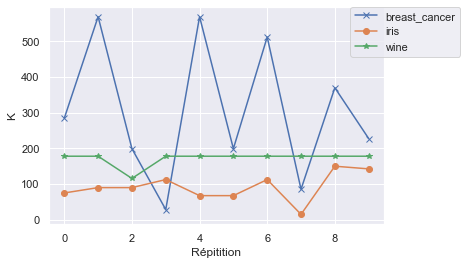

In [40]:


bc_mlm = optimal_k_over(breast_cancer.data,breast_cancer.target,'c')
iris_mlm = optimal_k_over(iris.data,iris.target,'c')
wine_mlm = optimal_k_over(wine.data,wine.target,'c')

plt.figure()
plt.plot(range(10),[i[1] for i in bc_mlm],"-x",label="breast_cancer")
plt.plot(range(10),[i[1] for i in iris_mlm],"-o",label="iris")
plt.plot(range(10),[i[1] for i in wine_mlm],"-*",label="wine")
plt.xlabel("Répitition")
plt.ylabel("K")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
plt.show()

## 4. Autres test

In [196]:
from sklearn.datasets import make_classification,make_moons,make_circles


In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification,make_moons,make_circles,make_regression

names = ["RBF SVM", "RF","MLM"]
####################################
classifiers = [
    svm_test,
    rf_test,
    mlm_test]
scores = []

###################################
def optimal_k(name,X_train, X_test, y_train, y_test):
    score_max = 0.
    best_k = 0.
    for i in np.arange(5,105,5):  
        clf = NN_MLM(rp_number=i/100)
        clf.fit(X_train,y_train)
        score = clf.score(X_test,y_test)
        if score > score_max:
            score_max  = score
            best_k = i/100
    return best_k
###################################
X, y = make_regression(n_samples=500,n_features=5,  n_informative=2,
                           random_state=1, )
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_regression(n_samples=500,n_features=5,  n_informative=2,
                           random_state=42, ),
            make_regression(n_samples=700,n_features=10,  n_informative=2,
                           random_state=42, ),
            make_regression(n_samples=600,n_features=7,  n_informative=2,
                           random_state=42, )
            ]
#################################
for X,y in datasets:
    df = to_pandas(X,y)
    print(svm_test(df,"r"))

0.028984379578800314
0.07451874360728863
0.054471862992934474


In [149]:
df = pd.DataFrame(data=scores,columns=names,index=["Data 1","Data 2","Data 3"])
display(df.style.apply(highlight_max,axis=1))


,RBF SVM,RF,MLM
make moon,0.970588,0.911765,0.911765
make circle,0.941176,0.941176,0.911765
linearly separable,0.970588,0.970588,0.941176


In [73]:
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor

X, y = make_regression(n_samples=600,n_features=3,random_state=1)

names = ["RBF SVM","Decision Tree", "Neural Net","MLM"]
####################################
Regressors = [
    SVR(gamma=2, C=1000),
    DecisionTreeRegressor(max_depth=5),
    MLPRegressor(alpha=1, max_iter=10000),
    MLM(.3)]

###################################
def optimal_k(X_train, X_test, y_train, y_test):
    score_max = 1e+10
    best_k = 0.
    for i in np.arange(5,105,5):  
        clf = MLM(rp_number=i/100)
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test,y_test)
        score = mean_squared_error(pred,y_test)
        if score < score_max:
            score_max  = score
            best_k = i/100
    return best_k

#################################

# preprocess dataset, split into training and test part
dataset = to_pandas(X,y)


    # iterate over classifiers

print("Regressor : {}, score : {}".format("SVM",svm_test(dataset,"r")))
print("Regressor : {}, score : {}".format("Decision Tree",dt_test(dataset,"r")))
print("Regressor : {}, score : {}".format("MLM",test(dataset,"r",1/3)))


### Time evolution according to the number of reference points

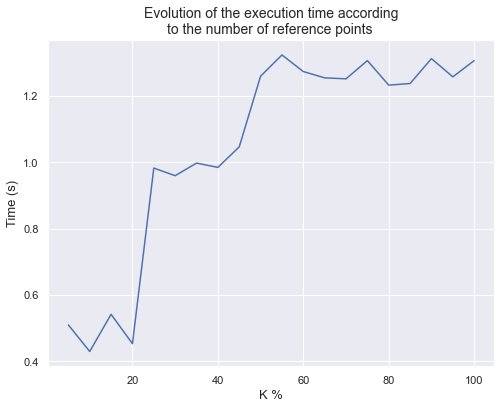

In [106]:
X, y = make_regression(n_samples=1000,n_features=2,random_state=1)
X,y = preprocessing(dataset)
X_train, X_test, y_train, y_test = split_and_norm(X,y,"r",test_size=1/3)
y_train = y_train.reshape((len(y_train),1))
T = []
for i in np.arange(5,105,5):  
    clf = MLM(rp_number=i/100)
    tps1 = time.time()
    pred = clf.fit(X_train,y_train).predict(X_test)
    tps2 = time.time()
    T.append(tps2-tps1)
    
plt.figure(figsize=(8,6))
plt.plot(np.arange(5,105,5),T)
plt.title("Evolution of the execution time according\nto the number of reference points ",fontsize=14)
plt.xlabel("K %",fontsize=13)
plt.ylabel("Time (s)",fontsize=13)
plt.show()

## Minimal Learning Machine with Random Forest Dissimilarities 
### a) Regression 

In [27]:
clf = mlm.RDFMLM_Regressor()
X,y = preprocessing(servo)
x_train, x_test, y_train, y_test = split_and_norm(X,y,"r",test_size=1/3)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Score :",mean_squared_error(pred,y_test))

Score : 0.6341926428647923


In [28]:
clf = mlm.RDFMLM_Regressor()
X,y = preprocessing(price)
x_train, x_test, y_train, y_test = split_and_norm(X,y,"r",test_size=1/3)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Score :",mean_squared_error(pred,y_test))

Score : 3214440.0038435007


In [29]:
clf = mlm.RDFMLM_Regressor()
X,y = preprocessing(housing)
x_train, x_test, y_train, y_test = split_and_norm(X,y,"r",test_size=1/3)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Score :",mean_squared_error(pred,y_test))

Score : 14.757476056368313


In [30]:
clf = mlm.RDFMLM_Regressor()
X,y = preprocessing(abalone)
x_train, x_test, y_train, y_test = split_and_norm(X,y,"r",test_size=1/3)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Score :",mean_squared_error(pred,y_test))

Score : 5.67925382721993


### Classification

In [33]:
clf = mlm.RDFMLM_Classifier()
X,y = preprocessing(iris)
x_train, x_test, y_train, y_test = split_and_norm(X,y,"r",test_size=1/3)
clf.fit(x_train,y_train)
print("Score :",clf.score(x_test,y_test))

Score : 0.96


In [34]:
clf = mlm.RDFMLM_Classifier()
X,y = preprocessing(wine)
x_train, x_test, y_train, y_test = split_and_norm(X,y,"r",test_size=1/3)
clf.fit(x_train,y_train)
print("Score :",clf.score(x_test,y_test))

Score : 0.9833333333333333


### Compare MLM, RF and RFMLM in high dimensional

In [128]:
from sklearn.datasets import make_classification,make_moons,make_circles,make_regression

s = []
for i in range(1,31):
    X, y = make_classification(n_samples=i*400, n_features=i*40, n_redundant=0, n_informative=2,n_classes=3,
                               random_state=42, n_clusters_per_class=1)

    df = to_pandas(X,y)
    X,y = preprocessing(df)
    X_train,X_test,y_train,y_test = split_and_norm(X,y,'c')


    clf = NN_MLM(1)
    clf.fit(X_train,y_train.reshape((len(y_train),1)))
    s.append(accuracy_score(y_test,clf.predict(X_test)))
    print("MLM : ",s[-1])

MLM :  0.696969696969697
MLM :  0.7030075187969925
MLM :  0.7361809045226131
MLM :  0.6760828625235404
MLM :  0.7757575757575758
MLM :  0.7836477987421384
MLM :  0.7150537634408602
MLM :  0.6939736346516008
MLM :  0.8196994991652755
MLM :  0.7293233082706767
MLM :  0.8441558441558441
MLM :  0.8250783699059561
MLM :  0.7109692396982008
MLM :  0.7375201288244766
MLM :  0.7259519038076152
MLM :  0.687793427230047
MLM :  0.8902169101372288
MLM :  0.7413288758880067
MLM :  0.754746835443038
MLM :  0.7122410546139359
MLM :  0.7325706113693242
MLM :  0.6866233321929525
MLM :  0.8605031035609279
MLM :  0.7313479623824451
MLM :  0.7743682310469314
MLM :  0.7836510687463893
MLM :  0.8750347898691901
MLM :  0.7577057089252212
MLM :  0.7509062661833247
MLM :  0.8551015292053146


In [118]:
res_rfmlm = np.array([0.9696969696969697,0.7076923076923077,0.8888888888888888, 0.803030303030303, 0.8554216867469879
, 0.875, 0.8879310344827587, 0.8383458646616542, 0.8417508417508418, 0.8734939759036144, 0.9281767955801105, 0.8467336683417085
, 0.8863109048723898, 0.8884120171673819, 0.9078156312625251, 0.8248587570621468, 0.8477876106194691, 0.9115191986644408
, 0.8936507936507937, 0.8893939393939394, 0.8744588744588745, 0.7980769230769231,  0.912303664921466, 0.9572327044025157
, 0.921875, 0.9722863741339491, 0.8943820224719101, 0.8387096774193549, 0.9315352697095436])
res_mlm=np.array(s)

(29,)

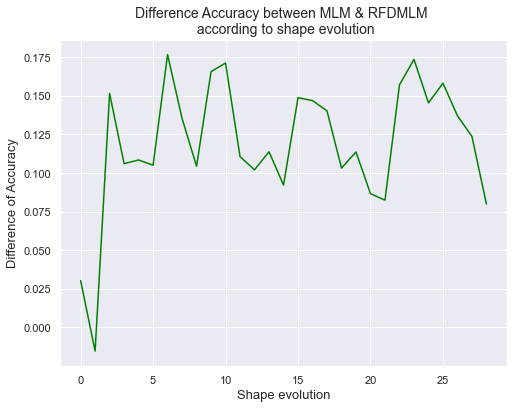

In [130]:
plt.figure(figsize=(8,6))
plt.title("Difference Accuracy between MLM & RFDMLM \n according to shape evolution",fontsize=14)
plt.xlabel("Shape evolution",fontsize=13)
plt.ylabel("Difference of Accuracy",fontsize=13)
plt.plot((res_rfmlm-res_mlm),label="RFDMLM",c='green')
plt.show()

In [133]:
np.mean(res_mlm[:5]),np.mean(res_mlm[15:20]),np.mean(res_rfmlm[:5]),np.mean(res_rfmlm[15:20])

(0.7687604497243051,
 0.7428974120605015,
 0.8449460312110915,
 0.8734420598781579)

In [101]:
s_r = []
for i in range(1,30):
    X, y = make_regression(n_samples=i*100, n_features=i*10, n_informative=2,
                               random_state=42)
    df = to_pandas(X,y)
    X,y = preprocessing(df)
    X_train,X_test,y_train,y_test = split_and_norm(X,y,'r')


    clf = MLM(1)
    clf.fit(X_train,y_train.reshape((len(y_train),1)))
    s_r.append(mean_squared_error(y_test,clf.predict(X_test)))
    print("MLM : ",s_r[-1])


MLM :  22.551297838631704
MLM :  113.64486720570976
MLM :  617.0105793448392
MLM :  756.493330154077
MLM :  1030.5003260699589
MLM :  1246.118759025779
MLM :  739.2451902799913
MLM :  37.94433378617344
MLM :  405.7765125931754
MLM :  329.6355774967844
MLM :  626.4223222249732
MLM :  367.80177190216057
MLM :  345.85580019894286
MLM :  472.4740552577811
MLM :  212.57244106267217
MLM :  237.3229026610694
MLM :  383.2071985231241
MLM :  83.34200026438067
MLM :  98.42391749250503
MLM :  413.4209705995388
MLM :  1011.7225770090997
MLM :  411.9670478927598
MLM :  348.3794412575162
MLM :  545.9847727315926
MLM :  821.389942070177
MLM :  300.2064222480251
MLM :  87.93417896067601
MLM :  753.7231138119253
MLM :  453.71281749939396


In [11]:
rfmlm_r=np.array([29.68511240097921, 69.57437242398458,  989.4040119175385, 688.0442581593887, 819.4488601020369, 634.0161792389123, 171.97592864756328
, 18.222135354525076, 123.16725341044071, 100.04829454532984, 160.55691619250024, 117.48715071426872, 68.70789279537149,124.54294086276398
, 30.647246430409506, 58.89883266748135,64.70174407111634,12.505911136707095, 18.950361871805768,84.79346440501247, 303.5664263275131
, 29.12822026855631,49.610707318100204,127.60446748134241,211.6011854274029,36.767163706737314
,11.767203934452208,98.00849368388984,62.168630713209694])
mlm_r = np.array([22.551297838631704,113.64486720570976,  617.0105793448392,  756.493330154077, 1030.5003260699589,  1246.118759025779
, 739.2451902799913,  37.94433378617344, 405.7765125931754, 329.6355774967844, 626.4223222249732, 367.80177190216057
, 345.85580019894286,  472.4740552577811,  212.57244106267217,  237.3229026610694,  383.2071985231241,  83.34200026438067
,  98.42391749250503,  413.4209705995388,  1011.7225770090997,  411.9670478927598,  348.3794412575162
, 545.9847727315926, 821.38994207017, 300.2064222480251, 87.93417896067601, 753.7231138119253,453.71281749939396])

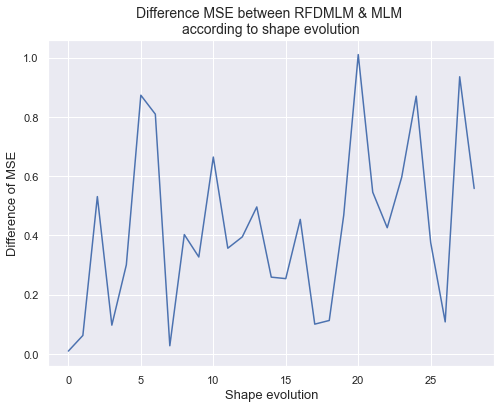

In [17]:
plt.figure(figsize=(8,6))
plt.title("Difference MSE between RFDMLM & MLM \naccording to shape evolution",fontsize=14)
plt.xlabel("Shape evolution",fontsize=13)
plt.ylabel("Difference of MSE",fontsize=13)
u = np.abs(mlm_r-rfmlm_r)
plt.plot(u/(u.max()-u.min()),label="RFDMLM")
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Time execution for each dataset",fontsize=14)
plt.xlabel("Shape evolution",fontsize=13)
plt.ylabel("Time(s)",fontsize=13)
plt.plot([0.62,0.14,0.28,0.7])
plt.plot([0.04,0.0002,0.01,0.06])
plt.plot([0.06,0.002,0.05,0.12])
plt.show()